# 第4回 数理生物研究 $\times$ 計算機

## 正方格子上での進化ゲームシミュレーション
ここでは，表題のシミュレーションをオブジェクト指向を用いたマルチエージェントシミュレーションとして実装する．

In [1]:
# 必要なライブラリをインポート
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Agentクラスを定義
* 変数
    - `strategy` : エージェントが持つ戦略 (協力を表す'C' or 非協力の'D' のいずれか)
    - `_next_strategy` : 同期更新時に使われる，次世代での戦略を一時保存する変数
    - `payoff` : エージェントが1世代で得た利得の合計
* メソッド
    - `__init__` : 初期化用
    - `reset` : 世代が変わるごとに行われる処理
    - `get_payoff` : エージェントに利得を与える
    - `find_next_strategy` : 近傍+自分自身から最大の利得を持つエージェントを選び，そのエージェントの戦略を次世代の戦略として一時保存
    - `update_strategy` : 一時保存してあった次世代の戦略で更新

In [2]:
class Agent:
    
    # 初期化用
    def __init__(self):
        # 協力 (C) か非協力 (D) をランダムに決める
        self.strategy = np.random.choice(['C', 'D'])
        
        # 次世代で使う戦略
        self._next_strategy = None
        
        # 世代ごとのリセット処理
        self.reset()
        
   

    # 世代ごとに実施されるリセット処理
    def reset(self):
        self.payoff = 0.0   # 利得を初期化
        

        
    # 利得を得る
    def get_payoff(self, p):
        self.payoff += p
        

        
    # 近傍エージェント+自分自身の中から
    # 最も利得の高い戦略を見つけて一時保存
    # (引数のneighbors は4近傍のエージェントリスト)
    def find_next_strategy(self, neighbors):
        
        # 近傍 + 自分のリストを作る
        list_with_me = neighbors + [self]
        # 同じ利得がいる場合に備えて，参照順をシャッフル
        np.random.shuffle(list_with_me)
        
        # 最大利得を持つエージェントを探す
        max_agent = list_with_me[0]                
        for i in range(1,len(list_with_me)):
            a = list_with_me[i]
            if a.payoff > max_agent.payoff:
                max_agent = a
        
        # 最大利得を持つエージェントの戦略をメモ
        self._next_strategy = max_agent.strategy

        
        
    # メモした次世代の戦略で更新 (同期更新用)
    def update_strategy(self):
        self.strategy = self._next_strategy

## シミュレーション用の関数群
* グローバル変数
    - `L` : 格子の一辺の長さ
    - `R` : 相互協力で得られる利得
    - `P` : 相互非協力で得られる利得
    - `S` : 自分が協力，相手が非協力のとき自分が得る利得
    - `T` : 自分が非協力，相手が協力のとき自分が得る利得
    - `pmatrix` : 利得行列 (辞書形式)
    - `agent_list` : Agentクラスのインスタンスが並べられた2次元リスト
    
* 関数
    - `initialize` : 全エージェントを初期化 (それぞれランダムに初期戦略を選択)
    - `reset` : 全エージェントの利得を初期化し直す
    - `play_games` : 全ての隣り合ったエージェント間でゲームを実施して利得を与える
    - `update_strategies` : 全エージェントの戦略を同期的に更新させる
    - `calc_C_frequency` : 協力者割合を計算して返す
    - `simulate` : 指定された世代数だけ進化させて協力者割合の変化をプロットする

In [7]:
#グローバル変数
L = 50     # 格子の一辺の長さ

R = 5.0    # 相互協力
S = 0.0    # 自分が協力，相手が非協力
T = 6.0    # 自分が非協力，相手が協力
P = 1.0    # 相互非協力
pmatrix = {       # 利得行列の辞書表現
    ('C','C'):R, 
    ('C','D'):S, 
    ('D','C'):T, 
    ('D','D'):P
}

agent_list = []   # エージェントのリスト





# 全エージェントを初期化
def initialize():
    # グローバル変数を使う宣言
    global L, agent_list
    
    # L×Lのエージェントが入ったリストを生成
    agent_list = [[Agent() for i in range(L)] 
                  for j in range(L)]   

    
    
    
# 全エージェントの利得を初期化し直す
def reset():
    global agent_list    # グローバル変数
    
    # それぞれのエージェントがリセット処理を行う
    for l in agent_list:
        for a in l:
            a.reset()
            


# 全ての隣り合ったエージェント間でゲームを実施して利得を与える
def play_games():
    # グローバル変数
    global agent_list, pmatrix
    
    # 二重 for 文でそれぞれのエージェントについて処理していく
    for i,l in enumerate(agent_list):
        for j,focal in enumerate(l):
            # focal が注目しているエージェント
            # (その座標が (i, j))
            
            '''
            4近傍の格子であるため，それぞれのエージェントが
            自分の左にいるエージェントおよび上にいるエージェントとゲームをすれば，
            全ての隣り合うエージェント同士で重複なくゲームが実施される
            '''
            
            # 左隣のエージェントをopp1とする
            opp1 = agent_list[i][j-1]
            
            ## 互いの戦略からゲームの利得を得る
            p_focal = pmatrix[(focal.strategy, 
                               opp1.strategy)]
            p_opp   = pmatrix[(opp1.strategy, 
                               focal.strategy)]
            
            ## focal へ利得を追加
            focal.get_payoff(p_focal)
            ## opp1 へ利得を追加
            opp1.get_payoff(p_opp)
            
            
            # 一つ上のエージェントをopp2とする
            opp2 = agent_list[i-1][j]
            
            ## 互いの戦略からゲームの利得を得る
            p_focal = pmatrix[(focal.strategy, 
                               opp2.strategy)]
            p_opp   = pmatrix[(opp2.strategy, 
                               focal.strategy)]
            
            ## focal へ利得を追加
            focal.get_payoff(p_focal)
            ## opp2 へ利得を追加
            opp2.get_payoff(p_opp)

            
            
# 全エージェントの戦略を同期的に更新させる
def update_strategies():
    # グローバル変数
    global L, agent_list
    
    # 二重 for 文でそれぞれのエージェントについて処理
    for i,l in enumerate(agent_list):
        for j,focal in enumerate(l):
            # focal が注目しているエージェント
            # (その座標が (i, j) )
            
            # focal の近傍エージェントを取得
            neighbors = [
                    agent_list[i-1][j],   # 上
                    agent_list[i][j-1],   # 左
                    agent_list[i+1-L][j], # 下
                    agent_list[i][j+1-L]  # 右
            ]
            
            # 近傍+自分の中で最も高い利得を持つエージェントを探させる
            # (その戦略をメモさせておく)
            focal.find_next_strategy(neighbors)

    # 全エージェントについて，メモさせた戦略で更新させる
    for l in agent_list:
        for focal in l:
            focal.update_strategy()


            
# 協力者割合を計算して返す
def calc_C_frequency():
    global agent_list    # グローバル変数
    
    # 協力者人数を数える
    nC = 0
    for l in agent_list:
        for focal in l:
            if focal.strategy == 'C':
                nC += 1
                
    # エージェント総数 (L×L) で割って協力者割合を返す
    return nC / (L**2)  
            

    
# 指定された世代数だけ進化させて協力者割合の変化をプロット
def simulate(Tmax=100):
    
    # 初期化
    initialize()
    # 協力者割合を記録
    fC_list = [calc_C_frequency()]
    
    # 世代を Tmax 回更新する
    for i in range(Tmax):
        reset()             # 利得のリセット
        play_games()        # ゲームさせる
        update_strategies() # 戦略を更新させる
        
        # 協力者割合を記録
        fC_list.append(calc_C_frequency())
        
        # 進捗確認用のバーを表示
        t = Tmax / 10
        if (i+1)%t == 0:
            print("*"*int((i+1)/t) + 
                "_"*(10-int((i+1)/t)), 
                f"{int((i+1)/Tmax*100):3d}%",  
                end='\r' if (i+1)<Tmax else '\n')
    
    # 協力者割合の変化をプロット
    plt.ylim(0,1)
    plt.xlabel('generation', fontsize=12)
    plt.ylabel('cooperation frequency', fontsize=12)
    plt.plot(fC_list)

## シミュレーションを実施
利得行列などのパラメータを変更したい場合は上のセルの最上部を直接変更する

********** 100%


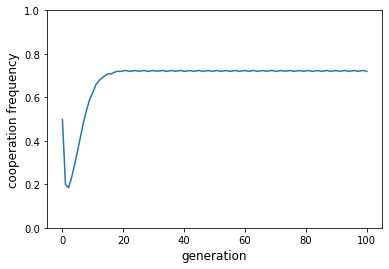

In [8]:
# 100 世代のシミュレーション
simulate(100)